# Attention-based GRN Inference on Fine-tuned Model

Here we use the fine-tuned blood model on the Adamson perturbation dataset as an
example of the cell-state specific GRN inference via attention weights. scGPT
outputs attention weights on the individual cell level, which can be further
aggregated by cell states. In this particular example, we compare the most
influenced genes between a transcription factor repression condition (perturbed)
and the control. However, this attention-based GRN inference is not restricted
to perturbation-based discoveries. It can also be used to compare between cell
states in general, such as healthy v.s. diseased, undifferentiated v.s.
differentiated, as a broader application.

Users may perform scGPT's attention-based GRN inference in the following steps:

     1. Load fine-tuned scGPT model and data

     2. Retrieve scGPT's attention weights by condition (i.e., cell states)

     3. Perform scGPT's rank-based most influenced gene selection

     4. Validate the most influenced gene list against existing databases


NOTE in advance: to run this tutorial notebook, you may need to download the
fine-tuned model from
[link](https://drive.google.com/drive/folders/1HsPrwYGPXm867_u_Ye0W4Ch8AFSneXAn)
and the list of targets of BHLHE40 from CHIP-Atlas for evaluation from
[link](https://drive.google.com/drive/folders/1nc1LywRHlzt4Z17McfXiqBWgoGbRNyc0).


In [5]:
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

In [26]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings
import pandas as pd
import pickle
import seaborn as sns
import gseapy as gp
from anndata import AnnData
import scanpy as sc
import numpy as np
from scipy.sparse import issparse


In [1]:
import torch
import matplotlib.pyplot as plt

import networkx as nx
from gears import PertData, GEARS

import scipy as sp
from einops import rearrange
from torch.nn.functional import softmax
from tqdm import tqdm


%autoreload 2

In [29]:
sys.path.insert(0, "../")

#import scgpt as scg
#from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
#from scgpt.model import TransformerModel
#from scgpt.utils import set_seed
from scgpt.tokenizer import tokenize_and_pad_batch
from scgpt.preprocess import Preprocessor

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings("ignore")

%reload_ext autoreload

In [6]:
print(torch.cuda.is_available())

NameError: name 'torch' is not defined

In [12]:
#set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

## Step 1: Load fine-tuned model and dataset


### 1.1 Load fine-tuned model

We are going to load a fine-tuned model for the gene interaction analysis on
Adamson dataset. The fine-tuned model can be downloaded via this
[link](https://drive.google.com/drive/folders/1HsPrwYGPXm867_u_Ye0W4Ch8AFSneXAn).
The dataset will be loaded in the next step 1.2.

To reproduce the provided fine-tuned model. Please followw the integration
fin-tuning pipeline to fine-tune the pre-trained blood model on the Adamson
perturbation dataset. Note that in the fine-tuning stage, we did not perform
highly vairable gene selection but trained on the 5000+ genes present in the
Adamson dataset. This is to provide flexbility in the inference stage to
investigate changes in attention maps across different perturbation conditions.


In [10]:
model_dir = Path("../save/scGPT_human")


In [13]:
vocab_file: Path = model_dir / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

In [5]:
# Specify model path; here we load the scGPT blood model fine-tuned on adamson
model_dir = Path("../save/scGPT_human")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"

# Retrieve model parameters from config files
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

Resume model from ../save/scGPT_human/best_model.pt, the model args will override the config ../save/scGPT_human/args.json.


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
    use_fast_transformer=True,
)

try:
    model.load_state_dict(torch.load(model_file))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)

Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.self_attn.Wqkv.weight with shape torch.Size([1536, 512])
Loading params transformer_encoder.layers.0.self_attn.Wqkv.bias with shape torch.Size([1536])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.self_attn.out

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashAttention()
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features

### 1.2 Load dataset of interest

The Adamson perturbation dataset is retrieved from the GEARS package with the
following code.


### first dataset

the first dataset is not scRNAseq but a specific method called scCAT-seq. very low correlation with previous dataset

similar to smart-seq 2 but with different procedures


need to be corrected for gene length

In [7]:
adata = AnnData((2**pd.read_csv('../../GroundTruth/remisdata/scRNA/liu_rna_filtered_log2.tsv', sep='\t'))-1).T

In [9]:
adata

AnnData object with n_obs × n_vars = 72 × 23153

In [10]:
set(adata.var.index) & set({'CDX2', 'FGFR2', 'HESX1', 'NANOG', 'OTX2', 'PHC1', 'POU5F1', 'REST', 'SOX2', "MYC", "KLF4"})

{'CDX2',
 'FGFR2',
 'HESX1',
 'KLF4',
 'MYC',
 'NANOG',
 'OTX2',
 'PHC1',
 'POU5F1',
 'REST',
 'SOX2'}

In [11]:
(adata.X==0).sum(axis=1) #not 

array([12207, 14268, 12306,  9580, 14278,  9939,  8698,  9698, 10375,
       11164, 11121, 10320, 11239, 11006, 10892, 10195, 12011, 11325,
       12669, 13332, 13680, 11362, 11027, 11646, 22661, 11878, 11930,
       11883, 11969, 15448, 15286, 14992, 14714, 14927, 13747, 14805,
       16020, 15101, 15254, 17996, 13858, 14862, 14879, 15441, 14098,
       14762, 23104, 13628, 14100, 13626, 13860, 13619, 12289, 13916,
       15183, 13502, 14565, 14461, 13612, 14768, 13811, 14453, 14727,
       14483, 13757, 14220, 13632, 14517, 15778, 14442, 11217,  9695])

In [12]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added='leiden_1.0', resolution=1.0)

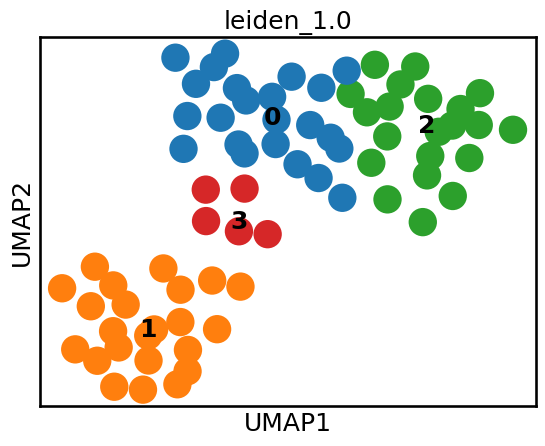

In [13]:
sc.pl.umap(adata, color=['leiden_1.0'], legend_loc='on data')

### second one

In [14]:
# adata = AnnData((2**pd.read_csv('../../GroundTruth/remisdata/scRNA/chen_rna_filtered_log2.tsv', sep='\t'))-1).T
# adata.X.max()

In [15]:
# adata.var

In [16]:
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)
# sc.tl.leiden(adata, key_added='leiden_1.0', resolution=1.0)

In [17]:
#sc.pl.umap(adata, color=['leiden_1.0'], legend_loc='on data')

### preprocessing

In [14]:
adata.var["id_in_vocab"] = [
    1 if gene in vocab else -1 for gene in adata.var.index
]
gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])

In [19]:
set(adata.var[adata.var["id_in_vocab"] < 0]) & set({'CDX2', 'FGFR2', 'HESX1', 'NANOG', 'OTX2', 'PHC1', 'POU5F1', 'REST', 'SOX2', "MYC", "KLF4"})

set()

In [22]:
adata = adata[:, adata.var["id_in_vocab"] >= 0]

In [21]:
adata.shape

(72, 17725)

In the scGPT workflow, we compare each TF perturbation condition with control
one at a time. In each run, the data is subsetted to contain one TF and control
only. In this example, we use the TF BHLHE40.


We further pre-process the subsetted data following the scGPT pipeline.


In [19]:
data_is_raw=True

In [23]:
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key="str_batch")

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


In [24]:
adata.shape

(72, 16804)

## Step 2: Retrieve scGPT's attention weights


### 2.1 Prepare model input


In [27]:
input_layer_key = "X_binned"
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var.index.tolist()
gene_ids = np.array(vocab(genes), dtype=int)

### 2.1 Retrieve attention weights

Note that since the flash-attn package does not output attention scores, we
manually calculate q @ k.T to extract the attention weights. Users may specify
which layer to extract the attention weights from. In the manuscript, we used
the attention weights from the last (12th) layer.


In [30]:
tokenized_all = tokenize_and_pad_batch(
        all_counts,
        gene_ids,
        max_len=len(genes) + 1,
        vocab=vocab,
        pad_token=pad_token,
        pad_value=pad_value,
        append_cls=True,  # append <cls> token at the beginning
        include_zero_gene=True,
    )

In [31]:
all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])

In [28]:
def get_attention(layer_num=11, batch_size=8):

    torch.cuda.empty_cache()
    dict_sum_condition = {}
    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
        M = all_gene_ids.size(1)
        N = all_gene_ids.size(0)
        device = next(model.parameters()).device
        for i in tqdm(range(0, N, batch_size)):
            batch_size = all_gene_ids[i : i + batch_size].size(0)
            outputs = np.zeros((batch_size, M, M), dtype=np.float32)
            # Replicate the operations in model forward pass
            src_embs = model.encoder(
                torch.tensor(all_gene_ids[i : i + batch_size], dtype=torch.long).to(device)
            )
            val_embs = model.value_encoder(
                torch.tensor(all_values[i : i + batch_size], dtype=torch.float).to(device)
            )
            total_embs = src_embs + val_embs
            # total_embs = model.layer(total_embs.permute(0, 2, 1)).permute(0, 2, 1)
            # Send total_embs to attention layers for attention operations
            # Retrieve the output from second to last layer
            for layer in model.transformer_encoder.layers[:layer_num]:
                total_embs = layer(
                    total_embs,
                    src_key_padding_mask=src_key_padding_mask[i : i + batch_size].to(
                        device
                    ),
                )
            # Send total_embs to the last layer in flash-attn
            # https://github.com/HazyResearch/flash-attention/blob/1b18f1b7a133c20904c096b8b222a0916e1b3d37/flash_attn/flash_attention.py#L90
            qkv = model.transformer_encoder.layers[layer_num].self_attn.Wqkv(
                total_embs
            )
            # Retrieve q, k, and v from flast-attn wrapper
            qkv = rearrange(qkv, "b s (three h d) -> b s three h d", three=3, h=8)
            q = qkv[:, :, 0, :, :]
            k = qkv[:, :, 1, :, :]
            v = qkv[:, :, 2, :, :]
            # https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a
            # q = [batch, gene, n_heads, n_hid]
            # k = [batch, gene, n_heads, n_hid]
            # attn_scores = [batch, n_heads, gene, gene]
            attn_scores = q.permute(0, 2, 1, 3) @ k.permute(0, 2, 3, 1)
            # apply softmax to get attention weights
            attn_scores = softmax(attn_scores, dim=-1)
            if i == 0:
                sm_attn_scores = attn_scores.sum(0).detach().cpu().numpy()
            else:
                # take the sum
                sm_attn_scores += attn_scores.sum(0).detach().cpu().numpy()
    gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()
    return sm_attn_scores
    # return [pd.DataFrame(data=sm_attn_scores[i], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx)) for i in range(0,8)]

In [29]:
sm_attn_scores = get_attention(11, 1)

  0%|          | 0/72 [00:00<?, ?it/s]

100%|██████████| 72/72 [08:43<00:00,  7.27s/it]


In [30]:
# save as pkl
#with open("./attn_scores_l11.pkl", "wb") as f:
#    pickle.dump(sm_attn_scores, f)

In [ ]:
sm_attn_scores.shape

(8, 16805, 16805)

In [1]:
# load
with open("./attn_scores_l11.pkl", "rb") as f:
    sm_attn_scores = pickle.load(f)

NameError: name 'pickle' is not defined

### trying with softmax

In [32]:
gene_vocab_idx = all_gene_ids[0].clone().detach().cpu().numpy()

In [ ]:
sm_attn_scores.shape

(8, 6586, 6586)

In [ ]:
(((sm_attn_scores>2).sum(1)>1).sum(0)>1).sum()

170

In [ ]:
(((sm_attn_scores>1).sum(1)>1).sum(0)>1).sum()

440

- 1000 genes have an attention score high across the 8 attention heads
- on avg 200 per attention heads
- 2000 have ok attention score across them all. meaning only 30% of the genes are really attended to

In [ ]:
sm_attn_scores[:,(sm_attn_scores>1).sum(1)>1].shape

IndexError: boolean index did not match indexed array along dimension 1; dimension is 6586 but corresponding boolean dimension is 8

only a tiny fraction of the data has high attention weights

In [ ]:
sm_attn_scores_h0 = pd.DataFrame(data=sm_attn_scores[0], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h0[(sm_attn_scores_h0>2).sum(0)>500].index

Index(['C20orf203', 'CALML3-AS1', 'EHMT2-AS1', 'EIF2S3B', 'EPHA1-AS1',
       'FAM157B', 'FAM3D-AS1', 'FAM95B1', 'LINC00330', 'LINC00501',
       'LINC00939', 'LINC01228', 'LINC01347', 'LINC01516', 'LINC01978',
       'LINC02023', 'LINC02280', 'LINC02447', 'LINC02474', 'NPIPA5', 'NPIPB13',
       'NPIPB2', 'PLA2G4E-AS1', 'POTEE', 'RGPD6', 'TRPV3', 'ZBTB7B'],
      dtype='object')

In [ ]:
set(sm_attn_scores_h0.index) & {'CDX2', 'FGFR2', 'HESX1', 'NANOG', 'OTX2', 'PHC1', 'POU5F1', 'REST', 'SOX2', "MYC", "KLF4"}

{'CDX2',
 'FGFR2',
 'HESX1',
 'KLF4',
 'MYC',
 'NANOG',
 'OTX2',
 'PHC1',
 'POU5F1',
 'REST',
 'SOX2'}

In [ ]:
set(sm_attn_scores_h0.index[(((sm_attn_scores>1).sum(1)>1).sum(0)>1)]) & {'CDX2', 'FGFR2', 'HESX1', 'NANOG', 'OTX2', 'PHC1', 'POU5F1', 'REST', 'SOX2', "MYC", "KLF4"}

set()

In [ ]:
sm_attn_scores_h0[(sm_attn_scores_h0 > 1).sum(0)>1].shape

(183, 16805)

In [ ]:
sm_attn_scores_h1 = pd.DataFrame(data=sm_attn_scores[1], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h1[(sm_attn_scores_h1>2).sum(0)>500].index

NameError: name 'gene_vocab_idx' is not defined

In [ ]:
sm_attn_scores_h2 = pd.DataFrame(data=sm_attn_scores[2], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h2[(sm_attn_scores_h2>2).sum(0)>500].index

Index(['AKAP9', 'ATRN', 'CALM1', 'CD47', 'CPSF6', 'DCUN1D4', 'ELP1', 'ETNK1',
       'EXT2', 'FBXO21', 'GNAS', 'HECTD1', 'LNPK', 'MAP3K7', 'MSH2', 'NF2',
       'NLRP2', 'OSGEPL1', 'PEX3', 'PLD2', 'PRKRIP1', 'RARS2', 'RBM5', 'SENP5',
       'SEPHS1', 'SND1', 'TMEM209', 'TSC22D1', 'TTC13', 'UFSP1', 'UQCC1',
       'USP30', 'YRDC', 'ZNF287'],
      dtype='object')

In [ ]:
sm_attn_scores_h3 = pd.DataFrame(data=sm_attn_scores[3], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h3[(sm_attn_scores_h3>2).sum(0)>500].index

Index(['AC099850.1', 'AC108676.1', 'ACADM', 'AIG1', 'BORCS7-ASMT', 'CALM1',
       'COCH', 'EFCAB10', 'FAM221B', 'GNAS', 'GSN-AS1', 'KLHL35', 'LACTB2-AS1',
       'LCTL', 'LINC00637', 'LINC01429', 'LINC01569', 'LINC02069', 'LINC02569',
       'LRRC23', 'PDZD9', 'PHACTR1', 'PITRM1-AS1', 'PP2D1', 'PRR34', 'RAB36',
       'RABGAP1L', 'RTN3', 'SMYD4', 'SOCS2-AS1', 'SPAG5-AS1', 'TDRD12',
       'TMEM17', 'TRIM68', 'TTC3', 'UCHL1', 'ZBTB20-AS4', 'ZCWPW1',
       'ZNF32-AS2', 'ZNRF3-AS1'],
      dtype='object')

In [ ]:
sm_attn_scores_h4 = pd.DataFrame(data=sm_attn_scores[4], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h4[(sm_attn_scores_h4>2).sum(0)>500].index

Index(['ARHGAP19', 'AURKA', 'BRIP1', 'C21orf58', 'CCDC150', 'CCDC18', 'CCNF',
       'CDCA3', 'CENPI', 'CEP128', 'CYP4A11', 'DNAH2', 'E2F8', 'ECT2L',
       'ESPL1', 'FBXO43', 'FTHL17', 'GEN1', 'INCA1', 'KAT2B', 'KIF18B',
       'LINC00658', 'LINC01301', 'LUZP4', 'M1AP', 'MAD2L1', 'MCM7',
       'MIS18A-AS1', 'MS4A18', 'MYCBPAP', 'NEIL3', 'PAGE5', 'PELI2',
       'PRMT5-AS1', 'PSMC3IP', 'RECQL4', 'RSPH9', 'TESK2', 'TOP2A', 'UNKL',
       'WFDC6', 'ZNF257', 'ZWINT'],
      dtype='object')

In [ ]:
sm_attn_scores_h5 = pd.DataFrame(data=sm_attn_scores[5], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h5[(sm_attn_scores_h5>2).sum(0)>500].index

Index(['ADAP2', 'AEN', 'ASS1', 'BRDT', 'CD86', 'CLDN2', 'CPA4', 'CSF1R',
       'CTSV', 'CX3CR1', 'CYP19A1', 'DPYS', 'ERBB3', 'FLI1', 'FMO3', 'GDA',
       'GJA1', 'GLYCTK', 'GRAMD2A', 'IRF8', 'MID1', 'MPP1', 'MS4A7', 'NCF4',
       'NFE2L3', 'NRSN1', 'PAGE1', 'PAPPA2', 'POR', 'PRAMEF11', 'PRR15', 'PTN',
       'SLC7A8', 'SOX4', 'SPARC', 'SYCP1', 'TBPL2', 'TMEM139', 'TPTEP1',
       'VGLL1'],
      dtype='object')

In [ ]:
sm_attn_scores_h6 = pd.DataFrame(data=sm_attn_scores[6], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h6[(sm_attn_scores_h6>2).sum(0)>500].index

Index(['BRICD5', 'C20orf203', 'CBX2', 'DNAJC30', 'FADS6', 'FAM78A', 'FDXACB1',
       'HSD17B1', 'LZTS1', 'NAPA-AS1', 'NCKAP5L', 'P2RY11', 'PLA2G6', 'PLCXD1',
       'PM20D2', 'RINL', 'TAF6', 'TNFRSF10A', 'TTLL12'],
      dtype='object')

In [ ]:
sm_attn_scores_h7 = pd.DataFrame(data=sm_attn_scores[7], columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))
sm_attn_scores_h7[(sm_attn_scores_h7>2).sum(0)>500].index

Index(['ARID3B', 'ATP6V0A2', 'BBS2', 'CEP97', 'DLG3', 'DPY19L3', 'ERVK13-1',
       'KLF8', 'MAGI2-AS3', 'MIPEP', 'NAA16', 'NADK2', 'PACS2', 'SIRT5',
       'SLC15A2', 'SLC27A1', 'TEX2', 'TMEM184B', 'TRAM2', 'UNKL', 'WWC3',
       'ZNRF3'],
      dtype='object')

'ATF3',
 'CBX8',
 'NANOG',
 'RXRA',
 'SAP30',

In [ ]:
- POU5F1 in h5
- JUN in h4
- NANOG in h3

In [ ]:
sm_attn_scores_h5[(sm_attn_scores_h5>2).sum(0)>300].index

Index(['ADAP2', 'AEN', 'APOA2', 'ASS1', 'BRDT', 'CA2', 'CABYR', 'CD34', 'CD86',
       'CLDN2', 'CNBD1', 'CPA4', 'CSF1R', 'CTSV', 'CX3CR1', 'CYP19A1',
       'CYP2B6', 'CYP2E1', 'DPYS', 'ERBB3', 'FER1L6-AS2', 'FLI1', 'FMO3',
       'GBP4', 'GDA', 'GJA1', 'GLYCTK', 'GRAMD2A', 'GTSF1', 'IRF8', 'LAMA3',
       'LINC01180', 'LINC01194', 'MID1', 'MPP1', 'MS4A7', 'NCF4', 'NFE2L3',
       'NRSN1', 'PAGE1', 'PAPPA2', 'PDCL3', 'POR', 'POU5F1', 'PRAMEF11',
       'PRR15', 'PTN', 'SLC51A', 'SLC7A8', 'SOX4', 'SPARC', 'SYCP1', 'TBPL2',
       'TESPA1', 'TMEM139', 'TPTEP1', 'TRAFD1', 'VGLL1'],
      dtype='object')

In [ ]:
(sm_attn_scores_h7.loc[:,[
 'CTBP2',
 'JUN',
 'KDM5A',
 'MYC',
 'POU5F1',
 'CDX2',
 'FGFR2',
 'NANOG',
 'SOX2',
 "KLF4",
 'REST',
 'SUZ12']]>2).sum(0)

CTBP2     0
JUN       0
KDM5A     0
MYC       0
POU5F1    0
CDX2      0
FGFR2     0
NANOG     0
SOX2      0
KLF4      0
REST      0
SUZ12     0
dtype: int64

In [ ]:
set(sm_attn_scores_h5[sm_attn_scores_h5['POU5F1']>2]['POU5F1'].index)

{'ABHD16A',
 'ACTN4',
 'ACTR10',
 'ACTR1A',
 'ACTR3',
 'ACTR6',
 'AGPAT1',
 'AGTRAP',
 'AKIRIN1',
 'AKIRIN2',
 'ANKRD13D',
 'AP3S1',
 'APEH',
 'APH1A',
 'ARIH2',
 'ARL2BP',
 'ARL5A',
 'ARL8A',
 'ARMCX1',
 'ARMCX3',
 'ASF1A',
 'ATP1A1',
 'ATP6V0D1',
 'ATP6V1B2',
 'AZI2',
 'B4GALT3',
 'BCAS2',
 'BIRC2',
 'BLOC1S6',
 'BNIP3L',
 'C12orf76',
 'C5orf15',
 'CALCOCO2',
 'CAPZA1',
 'CAPZA2',
 'CAST',
 'CAT',
 'CCAR2',
 'CCDC28A',
 'CCNDBP1',
 'CCNG1',
 'CCS',
 'CD44',
 'CD46',
 'CD74',
 'CDK16',
 'CDK2AP1',
 'CDK5R2',
 'CDK5RAP3',
 'CDV3',
 'CEBPG',
 'CEBPZOS',
 'CERS2',
 'CHID1',
 'CLDND1',
 'CLK3',
 'CNN2',
 'CNOT7',
 'COASY',
 'COPS2',
 'COPS7A',
 'COTL1',
 'CPNE1',
 'CREB3',
 'CREG1',
 'CSNK1D',
 'CSNK1E',
 'CTDSP1',
 'CTSF',
 'CXCL16',
 'CYTH2',
 'DAP3',
 'DDIT3',
 'DDIT4',
 'DDX54',
 'DHPS',
 'DMAP1',
 'DNAJB6',
 'DPF2',
 'DRAM2',
 'DUSP1',
 'DUSP6',
 'ECSIT',
 'EIF2A',
 'EIF2S3',
 'FAM53C',
 'FBXL12',
 'FDFT1',
 'FEZ2',
 'FGFR1OP2',
 'FLII',
 'FLOT1',
 'FRAT2',
 'FUNDC2',
 'FXR1',
 'GADD

we lack many of the key TF in ESCs: [SOX2, CDX2, NANOG, OTX2] which is weird as we would expect them to be expressed in ESCs

In [ ]:
set(sm_attn_scores_h1.index) & set({'CDX2', 'FGFR2', 'HESX1', 'NANOG', 'OTX2', 'PHC1', 'POU5F1', 'REST', 'SOX2'})

{'FGFR2', 'HESX1', 'PHC1', 'POU5F1', 'REST'}

In [ ]:
sm_attn_scores_h6

<cls>           A2M     A2ML1-AS1          AAAS      AACS  \
<cls>      5.469894e-24  3.603647e-11  2.041799e-07  7.020150e-10  0.708185   
A2M        4.798223e-12  4.946420e-08  2.742793e-04  1.758731e-05  0.172523   
A2ML1-AS1  1.109466e-16  1.566302e-07  2.817782e-06  4.867422e-07  0.297205   
AAAS       1.699819e-15  5.350672e-07  1.014307e-04  6.623388e-08  0.189294   
AACS       3.880906e-14  1.359513e-08  2.125757e-05  2.749306e-05  0.972692   
...                 ...           ...           ...           ...       ...   
ZWILCH     1.252163e-16  1.036182e-05  2.422251e-06  8.783523e-08  0.835561   
ZWINT      9.594151e-18  2.974966e-06  1.135038e-05  1.574183e-07  0.649088   
ZXDC       1.541514e-17  2.670330e-08  1.817235e-06  1.763488e-08  0.669788   
ZZEF1      1.609583e-16  1.166739e-09  2.273059e-06  9.532414e-08  0.270431   
ZZZ3       4.290574e-18  1.120718e-08  1.293920e-06  1.332238e-08  0.604702   

              AADAT      AAK1         AAMDC      AAR2     AARS2  ...  \
<cls>      0.007651  0.000012  7.700687e-14  0.000047  0.000928  ...   
A2M        0.011252  0.000519  7.123806e-08  0.002022  0.029963  ...   
A2ML1-AS1  0.000087  0.000673  2.001106e-09  0.000185  0.008028  ...   
AAAS       0.000007  0.000407  1.054625e-08  0.001084  0.012341  ...   
AACS       0.000001  0.000513  1.551357e-09  0.000322  0.020745  ...   
...             ...       ...           ...       ...       ...  ...   
ZWILCH     0.002058  0.000734  8.351669e-09  0.000540  0.005259  ...   
ZWINT      0.000388  0.000330  8.378746e-09  0.000187  0.008335  ...   
ZXDC       0.096134  0.000276  1.725254e-10  0.000635  0.004819  ...   
ZZEF1      0.012077  0.000442  2.672305e-10  0.000117  0.007739  ...   
ZZZ3       0.126026  0.000200  1.553595e-10  0.000332  0.003567  ...   

                ZSCAN29       ZSCAN30        ZSCAN9        ZSWIM6  \
<cls>      1.782746e-16  1.386043e-11  2.695617e-06  8.737299e-19   
A2M        1.836345e-09  4.309542e-06  2.292635e-04  2.758255e-11   
A2ML1-AS1  1.720960e-13  1.569618e-10  1.211341e-05  8.636718e-14   
AAAS       2.457057e-13  3.045493e-11  3.902227e-06  3.686557e-16   
AACS       1.046544e-11  3.298867e-08  9.372757e-07  2.325674e-11   
...                 ...           ...           ...           ...   
ZWILCH     6.045074e-14  6.847463e-11  3.240232e-04  9.457303e-16   
ZWINT      4.691893e-15  2.637299e-12  1.382981e-05  1.796030e-18   
ZXDC       2.653458e-12  1.234087e-08  1.109618e-04  1.978908e-13   
ZZEF1      1.038560e-09  3.187503e-07  1.691384e-04  1.067575e-10   
ZZZ3       2.548001e-11  1.362864e-08  2.129842e-04  2.954149e-13   

                 ZSWIM7        ZWILCH         ZWINT      ZXDC         ZZEF1  \
<cls>      1.369459e-11  2.154669e-06  4.198771e-13  0.000532  1.311442e-23   
A2M        1.213514e-06  5.472377e-05  1.936797e-07  0.001536  1.278936e-13   
A2ML1-AS1  1.721278e-07  1.015880e-05  7.139113e-09  0.000342  2.404030e-19   
AAAS       2.531728e-06  4.185665e-06  5.649630e-07  0.000347  2.417834e-20   
AACS       5.508788e-06  1.670348e-07  2.821232e-07  0.005588  2.905312e-15   
...                 ...           ...           ...       ...           ...   
ZWILCH     1.483636e-08  2.928368e-06  3.659824e-08  0.000459  1.035163e-20   
ZWINT      6.422682e-08  3.632369e-06  3.789042e-10  0.000094  4.157239e-23   
ZXDC       5.490104e-09  8.748338e-05  3.366627e-10  0.000789  7.575397e-18   
ZZEF1      4.216480e-09  2.749562e-05  6.876666e-10  0.038932  6.725706e-16   
ZZZ3       3.031629e-09  5.700217e-05  1.216658e-10  0.009301  9.199925e-17   

                   ZZZ3  
<cls>      3.497860e-07  
A2M        3.405679e-05  
A2ML1-AS1  4.924420e-06  
AAAS       1.897555e-05  
AACS       1.401923e-04  
...                 ...  
ZWILCH     4.871220e-06  
ZWINT      7.158479e-07  
ZXDC       3.557317e-06  
ZZEF1      9.574518e-05  
ZZZ3       7.232911e-07  

[6586 rows x 6586 columns]

0       6350
1         30
2         20
5         10
3          7
        ... 
6008       1
1875       1
33         1
6519       1
38         1
Length: 132, dtype: int64


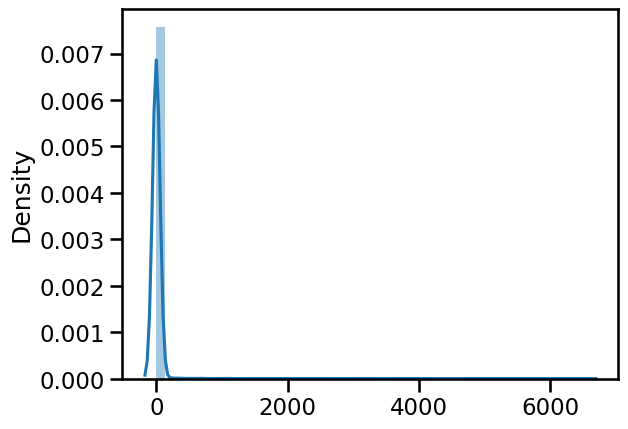

In [ ]:
#(sm_attn_scores_h0>2).sum()
# plot distribution
import seaborn as sns

sns.distplot((sm_attn_scores_h0>2).sum())

print((sm_attn_scores_h0>2).sum().value_counts())

In [44]:
from bertviz import head_view
import numpy as np


In [ ]:
SIZE = 70
LOC = 1000

In [ ]:

head_view([torch.FloatTensor([sm_attn_scores[:,LOC:LOC+SIZE,LOC:LOC+SIZE]])], sm_attn_scores_h0.index.tolist()[LOC:LOC+SIZE])

<IPython.core.display.Javascript object>

### how is attention changing across layers? 

In [ ]:
attention = get_attention(0, 1)

100%|██████████| 72/72 [08:35<00:00,  7.16s/it]


In [ ]:
attention.shape

(8, 16805, 16805)

In [ ]:
# save as pkl
#with open("./attn_scores_l0.pkl", "wb") as f:
#    pickle.dump(attention, f)

In [ ]:
# load pkl
with open("./attn_scores_l0.pkl", "rb") as f:
    attention = pickle.load(f)

In [ ]:
((attention[7]>2).sum(0)>500).sum()

51

In [ ]:
#sample some elements from attention
random_indices = np.random.randint(low=0, high=attention.shape[1], size=SIZE)
sampled_attention = attention[:, random_indices, :][:,:,random_indices]

In [ ]:
head_view([torch.FloatTensor([sampled_attention])], np.array(vocab.lookup_tokens(gene_vocab_idx))[random_indices].tolist())

<IPython.core.display.Javascript object>

In [ ]:
SIZE = 70
LOC = 80
head_view([torch.FloatTensor([attention[:,LOC:LOC+SIZE,LOC:LOC+SIZE]])], vocab.lookup_tokens(gene_vocab_idx)[LOC:LOC+SIZE])

<IPython.core.display.Javascript object>

In [ ]:
sm_attention = attention.sum(0).sum(0)

In [ ]:
sm_attention[sm_attention.argsort()[-100:]]

array([  10272.111 ,   10417.539 ,   10440.098 ,   10492.122 ,
         10497.043 ,   10776.554 ,   10830.762 ,   10957.552 ,
         11106.616 ,   11218.686 ,   11375.627 ,   11644.893 ,
         11734.144 ,   11850.473 ,   11873.858 ,   11892.34  ,
         11905.849 ,   11942.74  ,   12044.295 ,   12062.268 ,
         12124.112 ,   12399.449 ,   12503.957 ,   12535.965 ,
         12643.123 ,   12714.992 ,   12848.176 ,   13778.674 ,
         13857.691 ,   14224.541 ,   14530.182 ,   14617.979 ,
         14840.342 ,   14954.635 ,   15063.13  ,   15102.625 ,
         15110.671 ,   15139.022 ,   15431.235 ,   15441.4375,
         16018.611 ,   16056.949 ,   16086.735 ,   16255.052 ,
         16384.201 ,   16391.838 ,   16453.963 ,   16540.959 ,
         16572.346 ,   17341.518 ,   17435.184 ,   17738.117 ,
         17878.26  ,   18426.418 ,   18441.393 ,   19073.    ,
         19103.17  ,   19262.59  ,   19305.008 ,   19763.504 ,
         20612.48  ,   20875.98  ,   21032.486 ,   2144

In [53]:
np.array(vocab.lookup_tokens(gene_vocab_idx))[sm_attention.argsort()[-100:]]

NameError: name 'sm_attention' is not defined

In [ ]:
SIZE = 70
LOC = 2000
head_view([torch.FloatTensor([attention[:,LOC:LOC+SIZE,LOC:LOC+SIZE]])], vocab.lookup_tokens(gene_vocab_idx)[LOC:LOC+SIZE])

<IPython.core.display.Javascript object>

## total attention across all layers

In [94]:
attention.shape

(8, 16805, 16805)

In [ ]:
attention = [get_attention(i, 1) for i in range(0, 12)]

 21%|██        | 15/72 [02:56<11:09, 11.74s/it]


KeyboardInterrupt: 

In [95]:
# save as pkl
with open("./attn_scores_l0.pkl", "wb") as f:
    pickle.dump(attention, f)

## how is attention for predicting cell type? (is it focusing on marker genes?)

## trying sum of profiles

In [ ]:
voc = vocab.lookup_tokens(gene_vocab_idx)

In [37]:
voc[0]

'<cls>'

In [41]:
key_genes_cell_type = sm_attn_scores[:,0,:].sum(0).argsort()[-70:]

In [42]:
np.array(voc)[key_genes_cell_type]

array(['DPYSL2', 'C8orf37-AS1', 'LINC02069', 'LENG8-AS1', 'ZNF726',
       'LINC02408', 'LINC01237', 'ARF4-AS1', 'FLI1', 'LNPK', 'TPRG1-AS1',
       'RINL', 'BBS2', 'PRAMEF11', 'CALML3-AS1', 'NPIPB2', 'ARID3B',
       'EHMT2-AS1', 'FBXO21', 'TMEM164', 'RABGAP1L', 'LINC02447', 'WWC3',
       'FRS3', 'EAF1-AS1', 'TVP23C', 'ADAP2', 'PSPC1', 'ZCWPW1',
       'BORCS8-MEF2B', 'NUDCD3', 'DCAKD', 'LINC01516', 'LINC00330',
       'AC099850.1', 'MYCBPAP', 'ZNF287', 'DPY19L3', 'SLC7A8',
       'LINC01347', 'LINC02469', 'HSD17B1', 'TRAM2', 'ANKRD30B', 'INCA1',
       'PLA2G4E-AS1', 'ZNRF3', 'ECT2L', 'FDXACB1', 'TEX2', 'LINC00939',
       'C20orf203', 'ZDHHC11', 'SENP5', 'LINC00884', 'POTEE', 'TRIM68',
       'A2ML1-AS2', 'CCR1', 'FAM157B', 'SOCS2-AS1', 'RORA', 'SLC27A1',
       'KLF8', 'SMYD4', 'IRF8', 'M1AP', 'TTC23L', 'CD86', 'FOXD1'],
      dtype='<U25')

In [51]:
key_genes_cell_type = np.append(key_genes_cell_type,[0])

In [ ]:
head_view()

In [52]:
head_view([torch.FloatTensor([sm_attn_scores[:,key_genes_cell_type,:][:,:,key_genes_cell_type]])], np.array(voc)[key_genes_cell_type].tolist())

<IPython.core.display.Javascript object>

In [63]:
key_genes_cell_type = sm_attn_scores[1,0,:].argsort()[-100:]

In [64]:
np.array(voc)[key_genes_cell_type].tolist()[::-1]

['FOXD1',
 'ANKRD30B',
 'TVP23C',
 'TMEM64',
 'SIK2',
 'TRPM5',
 'CDH12',
 'LIPE-AS1',
 'RPTOR',
 'FBXL2',
 'SNTG2',
 'CYP2C19',
 'FAM160A1',
 'CNNM2',
 'MSX2',
 'SOX21-AS1',
 'ARL15',
 'PSORS1C2',
 'SLC2A13',
 'GULP1',
 'CDRT4',
 'PTPN21',
 'LINC00648',
 'CATSPERB',
 'CSRNP3',
 'MYRIP',
 'TBC1D32',
 'CCNT2-AS1',
 'KIAA1958',
 'RAPGEF3',
 'ARHGEF11',
 'MARK1',
 'PDE8A',
 'ZNF254',
 'PNPLA7',
 'USP49',
 'GPR173',
 'NAPEPLD',
 'TRERF1',
 'GATA3',
 'AP3B2',
 'ROBO1',
 'LINC01422',
 'KLF7',
 'TIAM2',
 'NECTIN3',
 'CDKL5',
 'WDPCP',
 'KIAA1549',
 'KITLG',
 'LARS2',
 'LRRC37A3',
 'CDC14B',
 'TTN-AS1',
 'CBFA2T2',
 'EXT1',
 'LRP12',
 'AMOT',
 'TMEM135',
 'PRKN',
 'ZNF407',
 'L2HGDH',
 'DSG1',
 'RNF157',
 'PLXNA2',
 'ICA1L',
 'KIAA1328',
 'GTDC1',
 'DLX2',
 'FNBP1L',
 'CCDC171',
 'CAB39L',
 'GABRE',
 'EFCAB5',
 'CSAD',
 'RUSC2',
 'BBS9',
 'TTC39B',
 'TMEM150C',
 'CELSR3',
 'RNF185-AS1',
 'SLC5A4-AS1',
 'LINC02522',
 'TPK1',
 'ZNF718',
 'SATB2',
 'ARSB',
 'ZNF676',
 'PRPH',
 'NRF1',
 'LINC00621

## focus on which TFs?

In [33]:
# load
with open("./attn_scores_l11.pkl", "rb") as f:
    sm_attn_scores = pickle.load(f)

In [34]:
sm_attn_scores = sm_attn_scores.sum(0)

In [ ]:
sm_attn_scores = pd.DataFrame(data=sm_attn_scores, columns=vocab.lookup_tokens(gene_vocab_idx), index=vocab.lookup_tokens(gene_vocab_idx))

In [39]:
sm_attn_scores[sm_attn_scores.sum(1)==0].index

Index([], dtype='object')

In [41]:
def fileToList(filename, strconv=lambda x: x):
    """
    loads an input file with a\\n b\\n.. into a list [a,b,..]
    """
    with open(filename) as f:
        return [strconv(val[:-1]) for val in f.readlines()]

In [ ]:
TFs = fileToList('./TF.txt')

In [50]:
set(TFs) - set(sm_attn_scores.index)

{'AC008770.3',
 'AC023509.3',
 'AC092835.1',
 'AC138696.1',
 'ALX4',
 'ANHX',
 'ARID3C',
 'ARNT2',
 'ASCL1',
 'ASCL4',
 'ASCL5',
 'ATOH1',
 'BARHL1',
 'BARHL2',
 'BCL11B',
 'BCL6B',
 'BHLHA15',
 'BHLHA9',
 'BHLHE23',
 'BHLHE41',
 'BSX',
 'CDX4',
 'CEBPE',
 'CPXCR1',
 'DACH1',
 'DBX1',
 'DBX2',
 'DMRT2',
 'DMRTA2',
 'DRGX',
 'DUX1',
 'DUX3',
 'DUX4',
 'EBF4',
 'EGR4',
 'EHF',
 'EMX1',
 'ETV7',
 'EVX1',
 'FAM170A',
 'FERD3L',
 'FEV',
 'FEZF1',
 'FEZF2',
 'FOXB1',
 'FOXB2',
 'FOXC2',
 'FOXD4',
 'FOXD4L1',
 'FOXD4L3',
 'FOXD4L6',
 'FOXE1',
 'FOXF1',
 'FOXF2',
 'FOXI1',
 'FOXI2',
 'FOXJ1',
 'FOXL1',
 'FOXL2',
 'FOXN1',
 'FOXN4',
 'FOXS1',
 'GATA1',
 'GATA5',
 'GBX1',
 'GLI1',
 'GLI2',
 'GLIS1',
 'GSC2',
 'GSX1',
 'GSX2',
 'GTF2I',
 'HDX',
 'HELT',
 'HES3',
 'HES5',
 'HES7',
 'HIC1',
 'HIVEP3',
 'HKR1',
 'HLF',
 'HMX1',
 'HMX2',
 'HMX3',
 'HNF1B',
 'HNF4G',
 'HOXA6',
 'HOXB1',
 'HOXB5',
 'HOXC12',
 'HOXC4',
 'HOXC5',
 'HOXC6',
 'HOXC8',
 'HOXD10',
 'HOXD12',
 'HOXD13',
 'HOXD4',
 'HSF4',
 'H

In [51]:
TFs = list(set(TFs) & set(sm_attn_scores.index))

In [ ]:
FOXD1 associated with NANOG https://pubmed.ncbi.nlm.nih.gov/37203394/
MXD3 is associated with increase nanog expression http://www.genomernai.org/v17/experimentSearch/GR00371-A-5
ZNF257
TRAFD1
SOX4 deficiency resulted in less nanog
IRF8 KD result in less nanog https://pubmed.ncbi.nlm.nih.gov/35227665/

In [59]:
sm_attn_scores[TFs].sum(1).mean(0)

62.058308

In [60]:
sm_attn_scores[~sm_attn_scores.columns.isin(TFs)].sum(1).mean(0)

576.0

In [55]:
#random location
sm_attn_scores.iloc[10][TFs].sort_values(ascending=False).head(20)

FOXD1     3.204972
ARID3B    3.156296
ZBTB7B    2.383945
CBX2      1.954079
ZNF566    1.620707
ZNF256    1.377972
MSX2      1.288430
ZBTB9     1.046426
ZNF446    0.959906
ZNF736    0.781586
ZNF222    0.757704
TFAP4     0.641468
ZNF287    0.638729
SOX2      0.612775
MEF2B     0.601143
GATA3     0.539304
ZNF445    0.537405
POU5F1    0.493823
MTF1      0.450243
PROX2     0.441169
Name: AAAS, dtype: float32

In [54]:
sm_attn_scores.loc['NANOG'][TFs].sort_values(ascending=False).head(20)

FOXD1      5.276187
MXD3       4.037051
ZNF257     3.728935
TRAFD1     2.788566
IRF8       2.321741
SOX4       2.271202
ZBTB7B     2.057247
ARID3B     2.026753
KLF5       1.729046
NFE2L3     1.321249
ZBTB9      1.148643
FLI1       0.665973
ZNF33B     0.658488
CBX2       0.648966
IKZF4      0.634151
OVOL1      0.556512
ZNF705A    0.547910
ZNF117     0.523978
RHOXF2B    0.496197
MSX2       0.494037
Name: NANOG, dtype: float32

### is the attention changing a lot when  giving similar profiles?